<a href="https://colab.research.google.com/github/TANISHQ8899/DIABETES-PROJECT-ML/blob/main/EN_ELM_ADASYN_iForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install scikit-learn pandas numpy matplotlib seaborn imbalanced-learn scipy


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import ADASYN
from scipy.special import expit
import warnings
warnings.filterwarnings('ignore')

In [11]:

# Set random seed for reproducibility
np.random.seed(42)


In [12]:
from google.colab import files
print("Please upload your heart disease dataset (CSV file):")
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nDataset Info:")
print(df.info())
print(f"\nMissing values:")
print(df.isnull().sum())

Please upload your heart disease dataset (CSV file):


Saving Heart_Dataset_Fresh_v2.csv to Heart_Dataset_Fresh_v2 (1).csv

Dataset loaded successfully!
Shape: (800, 10)

First few rows:
   age  sex   bp  cholesterol  max_heart_rate  blood_sugar  ecg_result  \
0   34    1  107          203              93            1           1   
1   61    0  134          206             170            0           1   
2   40    0   97          309             139            1           1   
3   25    0  105          180             148            0           2   
4   74    1  155          288             127            1           1   

   oldpeak  exercise_angina  target  
0     5.12                1       1  
1     2.15                1       0  
2     1.54                1       0  
3     0.63                1       1  
4     1.20                1       1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           -------

In [13]:
class DataPreprocessor:
    def __init__(self):
        self.scaler = MinMaxScaler()
        self.label_encoders = {}

    def handle_missing_values(self, df):
        """Handle missing values using mean imputation for numeric columns"""
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df[col].isnull().sum() > 0:
                df[col].fillna(df[col].mean(), inplace=True)
        return df

    def encode_categorical(self, df):
        """Encode categorical variables"""
        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if col in df.columns:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
                self.label_encoders[col] = le
        return df

    def detect_outliers(self, X, contamination=0.1):
        """Detect and remove outliers using Isolation Forest"""
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        outlier_labels = iso_forest.fit_predict(X)
        return outlier_labels != -1  # Return mask of non-outliers

    def balance_classes(self, X, y):
        """Balance classes using ADASYN"""
        try:
            adasyn = ADASYN(random_state=42)
            X_resampled, y_resampled = adasyn.fit_resample(X, y)
            print(f"Original dataset shape: {X.shape}")
            print(f"Resampled dataset shape: {X_resampled.shape}")
            return X_resampled, y_resampled
        except Exception as e:
            print(f"ADASYN failed: {e}. Using original data.")
            return X, y

    def normalize_data(self, X, fit=True):
        """Normalize data using Min-Max scaling"""
        if fit:
            return self.scaler.fit_transform(X)
        else:
            return self.scaler.transform(X)

# Initialize preprocessor
preprocessor = DataPreprocessor()

# Identify target column (usually the last column or named 'target', 'class', etc.)
target_col = df.columns[-1]  # Adjust if needed
print(f"\nTarget column: {target_col}")
print(f"Class distribution:\n{df[target_col].value_counts()}")

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Preprocessing steps
print("\n" + "="*50)
print("PREPROCESSING")
print("="*50)

# Handle missing values
X = preprocessor.handle_missing_values(X)

# Encode categorical variables
X = preprocessor.encode_categorical(X)

# Detect and remove outliers
print("\nDetecting outliers...")
non_outlier_mask = preprocessor.detect_outliers(X.values)
X = X[non_outlier_mask]
y = y[non_outlier_mask]
print(f"Removed {sum(~non_outlier_mask)} outliers")

# Normalize features
print("\nNormalizing features...")
X_normalized = preprocessor.normalize_data(X.values)

# Balance classes
print("\nBalancing classes using ADASYN...")
X_balanced, y_balanced = preprocessor.balance_classes(X_normalized, y.values)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.4, random_state=42, stratify=y_balanced
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")



Target column: target
Class distribution:
target
0    403
1    397
Name: count, dtype: int64

PREPROCESSING

Detecting outliers...
Removed 80 outliers

Normalizing features...

Balancing classes using ADASYN...
ADASYN failed: No samples will be generated with the provided ratio settings.. Using original data.

Training set size: 432
Testing set size: 288


In [14]:
class ELM:
    """Basic Extreme Learning Machine"""
    def __init__(self, n_hidden=100, activation='sigmoid', C=1.0):
        self.n_hidden = n_hidden
        self.activation = activation
        self.C = C
        self.input_weights = None
        self.biases = None
        self.output_weights = None

    def _activation_function(self, x):
        """Apply activation function"""
        if self.activation == 'sigmoid':
            return expit(x)
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'relu':
            return np.maximum(0, x)
        else:
            return x

    def fit(self, X, y):
        """Train the ELM"""
        n_samples, n_features = X.shape

        # Initialize input weights and biases randomly
        self.input_weights = np.random.randn(n_features, self.n_hidden)
        self.biases = np.random.randn(self.n_hidden)

        # Calculate hidden layer output
        H = self._activation_function(np.dot(X, self.input_weights) + self.biases)

        # Calculate output weights using Moore-Penrose pseudoinverse
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)

        # Regularized solution
        if H.shape[0] > H.shape[1]:
            self.output_weights = np.linalg.lstsq(
                H.T @ H + np.eye(H.shape[1]) / self.C,
                H.T @ y,
                rcond=None
            )[0]
        else:
            self.output_weights = H.T @ np.linalg.lstsq(
                H @ H.T + np.eye(H.shape[0]) / self.C,
                y,
                rcond=None
            )[0]

        return self

    def predict(self, X):
        """Make predictions"""
        H = self._activation_function(np.dot(X, self.input_weights) + self.biases)
        output = np.dot(H, self.output_weights)
        return (output > 0.5).astype(int).ravel()

    def predict_proba(self, X):
        """Predict probabilities"""
        H = self._activation_function(np.dot(X, self.input_weights) + self.biases)
        output = np.dot(H, self.output_weights)
        return expit(output).ravel()

In [15]:
class EGA_ELM:
    """ELM optimized with Enhanced Genetic Algorithm"""
    def __init__(self, n_hidden=100, population_size=50, max_iter=100,
                 crossover_prob=0.7, mutation_prob=0.3, elitism_rate=0.3):
        self.n_hidden = n_hidden
        self.population_size = population_size
        self.max_iter = max_iter
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.elitism_rate = elitism_rate
        self.best_elm = None

    def _fitness_function(self, weights, biases, X, y):
        """Calculate fitness (accuracy)"""
        elm = ELM(n_hidden=self.n_hidden)
        elm.input_weights = weights
        elm.biases = biases
        elm.fit(X, y)
        y_pred = elm.predict(X)
        return accuracy_score(y, y_pred)

    def fit(self, X, y):
        """Train ELM using Genetic Algorithm"""
        n_features = X.shape[1]

        # Initialize population
        population = []
        for _ in range(self.population_size):
            weights = np.random.randn(n_features, self.n_hidden)
            biases = np.random.randn(self.n_hidden)
            population.append((weights, biases))

        best_fitness = 0

        for iteration in range(self.max_iter):
            # Evaluate fitness
            fitness_scores = []
            for weights, biases in population:
                fitness = self._fitness_function(weights, biases, X, y)
                fitness_scores.append(fitness)

            # Update best
            current_best = max(fitness_scores)
            if current_best > best_fitness:
                best_fitness = current_best
                best_idx = fitness_scores.index(current_best)
                self.best_elm = ELM(n_hidden=self.n_hidden)
                self.best_elm.input_weights = population[best_idx][0]
                self.best_elm.biases = population[best_idx][1]
                self.best_elm.fit(X, y)

            # Elitism: keep best individuals
            elite_size = int(self.elitism_rate * self.population_size)
            elite_indices = np.argsort(fitness_scores)[-elite_size:]
            new_population = [population[i] for i in elite_indices]

            # Generate offspring
            while len(new_population) < self.population_size:
                # Tournament selection
                parent1 = population[np.random.choice(elite_indices)]
                parent2 = population[np.random.choice(elite_indices)]

                # Crossover
                if np.random.rand() < self.crossover_prob:
                    alpha = np.random.rand()
                    child_weights = alpha * parent1[0] + (1 - alpha) * parent2[0]
                    child_biases = alpha * parent1[1] + (1 - alpha) * parent2[1]
                else:
                    child_weights = parent1[0].copy()
                    child_biases = parent1[1].copy()

                # Mutation
                if np.random.rand() < self.mutation_prob:
                    mutation_strength = 0.1
                    child_weights += mutation_strength * np.random.randn(*child_weights.shape)
                    child_biases += mutation_strength * np.random.randn(*child_biases.shape)

                new_population.append((child_weights, child_biases))

            population = new_population

            if (iteration + 1) % 20 == 0:
                print(f"Iteration {iteration+1}/{self.max_iter}, Best Fitness: {best_fitness:.4f}")

        return self

    def predict(self, X):
        return self.best_elm.predict(X)

    def predict_proba(self, X):
        return self.best_elm.predict_proba(X)

In [16]:
# ============================================================================
class EPSO_ELM:
    """ELM optimized with Enhanced Particle Swarm Optimization"""
    def __init__(self, n_hidden=100, n_particles=50, max_iter=100,
                 c1=1.5, c2=1.5, w=0.7):
        self.n_hidden = n_hidden
        self.n_particles = n_particles
        self.max_iter = max_iter
        self.c1 = c1
        self.c2 = c2
        self.w = w
        self.best_elm = None

    def fit(self, X, y):
        """Train ELM using Particle Swarm Optimization"""
        n_features = X.shape[1]
        param_dim = n_features * self.n_hidden + self.n_hidden

        # Initialize particles
        particles = np.random.randn(self.n_particles, param_dim) * 0.5
        velocities = np.random.randn(self.n_particles, param_dim) * 0.1

        # Initialize personal and global bests
        personal_best = particles.copy()
        personal_best_fitness = np.full(self.n_particles, -np.inf)
        global_best = particles[0].copy()
        global_best_fitness = -np.inf

        for iteration in range(self.max_iter):
            for i in range(self.n_particles):
                # Decode particle to weights and biases
                params = particles[i]
                weights = params[:n_features * self.n_hidden].reshape(n_features, self.n_hidden)
                biases = params[n_features * self.n_hidden:]

                # Evaluate fitness
                elm = ELM(n_hidden=self.n_hidden)
                elm.input_weights = weights
                elm.biases = biases
                elm.fit(X, y)
                fitness = accuracy_score(y, elm.predict(X))

                # Update personal best
                if fitness > personal_best_fitness[i]:
                    personal_best_fitness[i] = fitness
                    personal_best[i] = particles[i].copy()

                # Update global best
                if fitness > global_best_fitness:
                    global_best_fitness = fitness
                    global_best = particles[i].copy()
                    self.best_elm = elm

            # Update velocities and positions with exponential decay
            w_current = self.w * np.exp(-iteration / self.max_iter)

            for i in range(self.n_particles):
                r1, r2 = np.random.rand(2)
                velocities[i] = (w_current * velocities[i] +
                               self.c1 * r1 * (personal_best[i] - particles[i]) +
                               self.c2 * r2 * (global_best - particles[i]))

                # Apply velocity limits
                velocities[i] = np.clip(velocities[i], -2, 2)
                particles[i] += velocities[i]

            if (iteration + 1) % 20 == 0:
                print(f"Iteration {iteration+1}/{self.max_iter}, Best Fitness: {global_best_fitness:.4f}")

        return self

    def predict(self, X):
        return self.best_elm.predict(X)

    def predict_proba(self, X):
        return self.best_elm.predict_proba(X)

In [17]:
class KELM:
    """Kernel Extreme Learning Machine"""
    def __init__(self, n_hidden=100, kernel='rbf', C=1.0, gamma=0.1):
        self.n_hidden = n_hidden
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.X_train = None
        self.alpha = None

    def _kernel_function(self, X1, X2):
        """Compute kernel matrix"""
        if self.kernel == 'rbf':
            from scipy.spatial.distance import cdist
            K = np.exp(-self.gamma * cdist(X1, X2, 'sqeuclidean'))
        elif self.kernel == 'linear':
            K = np.dot(X1, X2.T)
        else:
            K = np.dot(X1, X2.T)
        return K

    def fit(self, X, y):
        """Train KELM"""
        self.X_train = X
        K = self._kernel_function(X, X)

        if len(y.shape) == 1:
            y = y.reshape(-1, 1)

        # Solve for alpha
        self.alpha = np.linalg.solve(
            K + np.eye(K.shape[0]) / self.C,
            y
        )
        return self

    def predict(self, X):
        """Make predictions"""
        K = self._kernel_function(X, self.X_train)
        output = np.dot(K, self.alpha)
        return (output > 0.5).astype(int).ravel()

    def predict_proba(self, X):
        """Predict probabilities"""
        K = self._kernel_function(X, self.X_train)
        output = np.dot(K, self.alpha)
        return expit(output).ravel()

In [18]:
class EN_ELM:
    """Ensemble Extreme Learning Machine"""
    def __init__(self, n_hidden=100, threshold=0.85, n_subsets=5):
        self.n_hidden = n_hidden
        self.threshold = threshold
        self.n_subsets = n_subsets
        self.models = []

    def fit(self, X, y):
        """Train ensemble of ELM models"""
        print("\n" + "="*50)
        print("TRAINING ENSEMBLE ELM")
        print("="*50)

        # Train EGA-ELM
        print("\n1. Training EGA-ELM...")
        ega_elm = EGA_ELM(n_hidden=self.n_hidden, population_size=75, max_iter=100)
        ega_elm.fit(X, y)
        self.models.append(('EGA-ELM', ega_elm))

        # Train EPSO-ELM
        print("\n2. Training EPSO-ELM...")
        epso_elm = EPSO_ELM(n_hidden=self.n_hidden, n_particles=40, max_iter=100)
        epso_elm.fit(X, y)
        self.models.append(('EPSO-ELM', epso_elm))

        # Train KELM
        print("\n3. Training KELM...")
        kelm = KELM(n_hidden=self.n_hidden, C=1.0, gamma=0.1)
        kelm.fit(X, y)
        self.models.append(('KELM', kelm))

        print("\nEnsemble training completed!")
        return self

    def predict(self, X):
        """Make ensemble predictions with confidence-based voting"""
        predictions = []
        probabilities = []

        for name, model in self.models:
            pred = model.predict(X)
            proba = model.predict_proba(X)
            predictions.append(pred)
            probabilities.append(proba)

        predictions = np.array(predictions)
        probabilities = np.array(probabilities)

        final_predictions = []

        for i in range(X.shape[0]):
            # Check if any model has confidence > threshold
            max_confidence = np.max(probabilities[:, i])

            if max_confidence > self.threshold:
                # Use the prediction from the most confident model
                best_model_idx = np.argmax(probabilities[:, i])
                final_predictions.append(predictions[best_model_idx, i])
            else:
                # Use majority voting
                vote = np.bincount(predictions[:, i].astype(int))
                final_predictions.append(np.argmax(vote))

        return np.array(final_predictions)

    def evaluate(self, X, y):
        """Evaluate ensemble performance"""
        y_pred = self.predict(X)

        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, average='binary', zero_division=0)
        recall = recall_score(y, y_pred, average='binary', zero_division=0)
        f1 = f1_score(y, y_pred, average='binary', zero_division=0)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'sensitivity': recall,
            'specificity': self._calculate_specificity(y, y_pred),
            'f1_score': f1
        }

    def _calculate_specificity(self, y_true, y_pred):
        """Calculate specificity"""
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            return tn / (tn + fp) if (tn + fp) > 0 else 0
        return 0


In [19]:
print("\n" + "="*70)
print("STARTING MODEL TRAINING")
print("="*70)

# Initialize and train EN-ELM
en_elm = EN_ELM(n_hidden=100, threshold=0.85, n_subsets=5)
en_elm.fit(X_train, y_train)



STARTING MODEL TRAINING

TRAINING ENSEMBLE ELM

1. Training EGA-ELM...
Iteration 20/100, Best Fitness: 0.6898
Iteration 40/100, Best Fitness: 0.6944
Iteration 60/100, Best Fitness: 0.6991
Iteration 80/100, Best Fitness: 0.6991
Iteration 100/100, Best Fitness: 0.6991

2. Training EPSO-ELM...
Iteration 20/100, Best Fitness: 0.6852
Iteration 40/100, Best Fitness: 0.6875
Iteration 60/100, Best Fitness: 0.6875
Iteration 80/100, Best Fitness: 0.6921
Iteration 100/100, Best Fitness: 0.6921

3. Training KELM...

Ensemble training completed!


In [20]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Evaluate on training set
print("\n--- Training Set Performance ---")
train_metrics = en_elm.evaluate(X_train, y_train)
for metric, value in train_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f} ({value*100:.2f}%)")

# Evaluate on testing set
print("\n--- Testing Set Performance ---")
test_metrics = en_elm.evaluate(X_test, y_test)
for metric, value in test_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f} ({value*100:.2f}%)")



MODEL EVALUATION

--- Training Set Performance ---
Accuracy: 0.6574 (65.74%)
Precision: 0.6605 (66.05%)
Sensitivity: 0.6544 (65.44%)
Specificity: 0.6605 (66.05%)
F1_score: 0.6574 (65.74%)

--- Testing Set Performance ---
Accuracy: 0.5035 (50.35%)
Precision: 0.5030 (50.30%)
Sensitivity: 0.5903 (59.03%)
Specificity: 0.4167 (41.67%)
F1_score: 0.5431 (54.31%)


In [21]:

# Generate predictions
y_pred = en_elm.predict(X_test)

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))


--- Confusion Matrix ---
[[60 84]
 [59 85]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.50      0.42      0.46       144
           1       0.50      0.59      0.54       144

    accuracy                           0.50       288
   macro avg       0.50      0.50      0.50       288
weighted avg       0.50      0.50      0.50       288




GENERATING VISUALIZATIONS


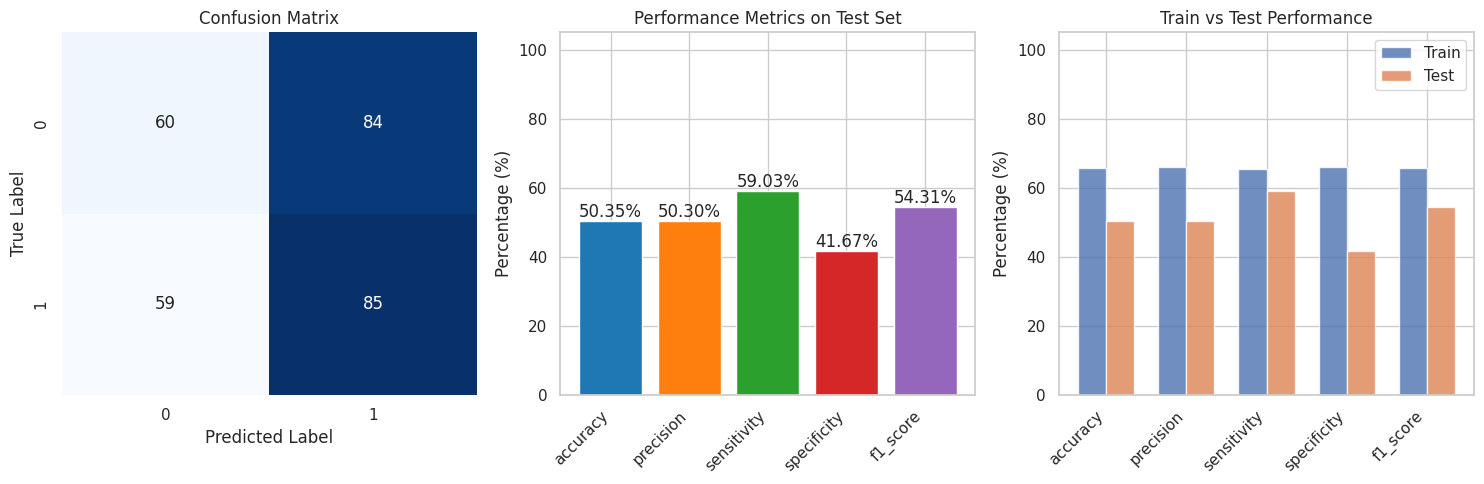


Visualization saved as 'en_elm_results.png'


In [22]:
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Plot 1: Confusion Matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot 2: Performance Metrics Comparison
plt.subplot(1, 3, 2)
metrics_names = list(test_metrics.keys())
metrics_values = [test_metrics[m] * 100 for m in metrics_names]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylabel('Percentage (%)')
plt.title('Performance Metrics on Test Set')
plt.ylim([0, 105])
plt.xticks(rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%', ha='center', va='bottom')

# Plot 3: Train vs Test Comparison
plt.subplot(1, 3, 3)
x = np.arange(len(metrics_names))
width = 0.35
train_values = [train_metrics[m] * 100 for m in metrics_names]
test_values = [test_metrics[m] * 100 for m in metrics_names]

plt.bar(x - width/2, train_values, width, label='Train', alpha=0.8)
plt.bar(x + width/2, test_values, width, label='Test', alpha=0.8)
plt.ylabel('Percentage (%)')
plt.title('Train vs Test Performance')
plt.xticks(x, metrics_names, rotation=45, ha='right')
plt.legend()
plt.ylim([0, 105])

plt.tight_layout()
plt.savefig('en_elm_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'en_elm_results.png'")

In [23]:
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"\nDataset: {filename}")
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Number of features: {X.shape[1]}")
print(f"Hidden neurons: {en_elm.n_hidden}")
print(f"Classification threshold: {en_elm.threshold}")

print(f"\n{'='*70}")
print("FINAL RESULTS ON TEST SET")
print(f"{'='*70}")
print(f"Accuracy:    {test_metrics['accuracy']*100:.2f}%")
print(f"Sensitivity: {test_metrics['sensitivity']*100:.2f}%")
print(f"Specificity: {test_metrics['specificity']*100:.2f}%")
print(f"Precision:   {test_metrics['precision']*100:.2f}%")
print(f"F1-Score:    {test_metrics['f1_score']*100:.2f}%")
print(f"{'='*70}\n")

print("✓ Model training and evaluation completed successfully!")


SUMMARY

Dataset: Heart_Dataset_Fresh_v2 (1).csv
Total samples: 800
Training samples: 432
Testing samples: 288
Number of features: 9
Hidden neurons: 100
Classification threshold: 0.85

FINAL RESULTS ON TEST SET
Accuracy:    50.35%
Sensitivity: 59.03%
Specificity: 41.67%
Precision:   50.30%
F1-Score:    54.31%

✓ Model training and evaluation completed successfully!
